In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
from dotenv import load_dotenv, find_dotenv
from path import Path
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_auc_score, cohen_kappa_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

# load the env file when called
load_dotenv(Path('../PATH.env'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/abdel/Documents/mmg-clip/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# torch.cuda.empty_cache()

In [31]:
def create_path(id):
    '''A callback function to create a string path to the image with the specific id passed.
    It can handle receiving a view id or a patient id.

    Args:
        id: a string id for either the patient or the image view.

    Returns: 
        A list of string paths for the given id. 
    
    '''
    base_dataset_path = os.getenv("DATASET_PATH")
    
    if isinstance(id, str) and id[0][0] == 'p':
        # check the first id if it has letter 'p' indicating a specific study view.
        path = os.path.join(base_dataset_path, id[1:3], id[1:9], f"st{id[9:11]}", f"{id}.png")
        return path
    
    elif isinstance(id, str) and len(id)== 8:
        # this indicates a patient id
        studies_path = os.path.join(base_dataset_path, id[0:2], id)
        views_paths = []

        for study in os.listdir(studies_path):
            study_path = os.path.join(studies_path, study)

            for view in os.listdir(study_path):
                view_path = os.path.join(study_path, view)
                views_paths.append(view_path)

        return views_paths 


In [32]:
model_path = '../mmgclip/models/image_encoders/clf_convnext_tiny/classifier_convnext_tiny_16bits_images.pt'
data_path  = '../data/02_data_lists/data/lists'
os.listdir(data_path)

['normal_patients.txt', 'malignant_patients.txt', 'ilst']

Creating malignant only dataset

In [33]:
malignant_path = os.path.join(data_path, 'ilst/only_malignant_images_views.txt')
malignant_dataset = pd.read_csv(malignant_path, sep=" ")
malignant_dataset.head()

,image_id
0,p0200000601cl
1,p0200000601ml
2,p0200001101cr
3,p0200001101mr
4,p0200001301ml


In [34]:
malignant_dataset['image_path'] = malignant_dataset['image_id'].apply(create_path)
malignant_dataset['image_path'].head()

0    /storage/Features/features/png_archive/2D_100m...
1    /storage/Features/features/png_archive/2D_100m...
2    /storage/Features/features/png_archive/2D_100m...
3    /storage/Features/features/png_archive/2D_100m...
4    /storage/Features/features/png_archive/2D_100m...
Name: image_path, dtype: object

In [59]:
malignant_dataset['label'] = 1
print(len(malignant_dataset))
malignant_dataset.head()

2662


,image_id,image_path,label
0,p0200000601cl,/storage/Features/features/png_archive/2D_100m...,1
1,p0200000601ml,/storage/Features/features/png_archive/2D_100m...,1
2,p0200001101cr,/storage/Features/features/png_archive/2D_100m...,1
3,p0200001101mr,/storage/Features/features/png_archive/2D_100m...,1
4,p0200001301ml,/storage/Features/features/png_archive/2D_100m...,1


Creating normal patient dataset

In [36]:
normal_patient_path = os.path.join(data_path, 'normal_patients.txt')
normal_patient_dataset = pd.read_csv(normal_patient_path, sep=" ", dtype=str)
normal_patient_dataset.head()

,patient_id
0,02000001
1,02000002
2,02000003
3,02000004
4,02000008


In [37]:
normal_patient_dataset['views_paths'] = normal_patient_dataset['patient_id'].apply(create_path)
normal_patient_dataset.head()

,patient_id,views_paths
0,02000001,[/storage/Features/features/png_archive/2D_100...
1,02000002,[/storage/Features/features/png_archive/2D_100...
2,02000003,[/storage/Features/features/png_archive/2D_100...
3,02000004,[/storage/Features/features/png_archive/2D_100...
4,02000008,[/storage/Features/features/png_archive/2D_100...


In [38]:
# each patient could have multiple studies and multiple views per study
normal_patient_dataset.iloc[:1]['views_paths'][0]

['/storage/Features/features/png_archive/2D_100micron/0/02/02000001/st01/p0200000101cr.png',
 '/storage/Features/features/png_archive/2D_100micron/0/02/02000001/st01/p0200000101mr.png',
 '/storage/Features/features/png_archive/2D_100micron/0/02/02000001/st01/p0200000101ml.png',
 '/storage/Features/features/png_archive/2D_100micron/0/02/02000001/st01/p0200000101cl.png',
 '/storage/Features/features/png_archive/2D_100micron/0/02/02000001/st00/p0200000100cr.png',
 '/storage/Features/features/png_archive/2D_100micron/0/02/02000001/st00/p0200000100cl.png',
 '/storage/Features/features/png_archive/2D_100micron/0/02/02000001/st00/p0200000100ml.png',
 '/storage/Features/features/png_archive/2D_100micron/0/02/02000001/st00/p0200000100mr.png']

In [39]:
# restructuring the dataset moving it from patient level to image view level
rows = []
for index, row in normal_patient_dataset.iterrows():
    for img_view in row['views_paths']:
        image_id = img_view.split('/')[-1].replace('.png', '')
        rows.append([image_id, img_view, 0])

normal_patient_dataset_restructured = pd.DataFrame(rows, columns=['image_id', 'image_path', 'label'])
normal_patient_dataset_restructured

,image_id,image_path,label
0,p0200000101cr,/storage/Features/features/png_archive/2D_100m...,0
1,p0200000101mr,/storage/Features/features/png_archive/2D_100m...,0
2,p0200000101ml,/storage/Features/features/png_archive/2D_100m...,0
3,p0200000101cl,/storage/Features/features/png_archive/2D_100m...,0
4,p0200000100cr,/storage/Features/features/png_archive/2D_100m...,0
...,...,...,...
27002,p0202023600cl,/storage/Features/features/png_archive/2D_100m...,0
27003,p0202041100ml,/storage/Features/features/png_archive/2D_100m...,0
27004,p0202041100cl,/storage/Features/features/png_archive/2D_100m...,0
27005,p0202041100cr,/storage/Features/features/png_archive/2D_100m...,0


Now we have 2 datasets (DataFrames), which are `malignant_dataset` and `normal_patient_dataset_restructured` with the same columns from two classes. We can combine them and pass them for inference. 

In [40]:
print(malignant_dataset.sample())
print(normal_patient_dataset_restructured.sample())

          image_id                                         image_path  label
559  p0200123402mr  /storage/Features/features/png_archive/2D_100m...      1
            image_id                                         image_path  label
23223  p0201324501ml  /storage/Features/features/png_archive/2D_100m...      0


In [41]:
final_dataset = pd.concat([malignant_dataset, normal_patient_dataset_restructured], ignore_index=True)
final_dataset

,image_id,image_path,label
0,p0200000601cl,/storage/Features/features/png_archive/2D_100m...,1
1,p0200000601ml,/storage/Features/features/png_archive/2D_100m...,1
2,p0200001101cr,/storage/Features/features/png_archive/2D_100m...,1
3,p0200001101mr,/storage/Features/features/png_archive/2D_100m...,1
4,p0200001301ml,/storage/Features/features/png_archive/2D_100m...,1
...,...,...,...
29664,p0202023600cl,/storage/Features/features/png_archive/2D_100m...,0
29665,p0202041100ml,/storage/Features/features/png_archive/2D_100m...,0
29666,p0202041100cl,/storage/Features/features/png_archive/2D_100m...,0
29667,p0202041100cr,/storage/Features/features/png_archive/2D_100m...,0


In [62]:
# # 7622 is a failed example from the model run, not an image?
# sample_img = Image.open(
#     final_dataset.iloc[7622]['image_path']
# )
# display(sample_img)
# print(sample_img.size)

(5, 76)


Model Prediction

In [43]:
softmax = torch.nn.Softmax(dim=1)
transform = transforms.Compose([transforms.ToTensor()])

model = torch.jit.load(model_path)
model = model.to(device)
model.eval()

RecursiveScriptModule(
  original_name=ConvNeXt_spm
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=Conv2dNormActivation
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=LayerNorm2d)
    )
    (1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=CNBlock
        (block): RecursiveScriptModule(
          original_name=Sequential
          (0): RecursiveScriptModule(original_name=Conv2d)
          (1): RecursiveScriptModule(original_name=Permute)
          (2): RecursiveScriptModule(original_name=LayerNorm)
          (3): RecursiveScriptModule(original_name=Linear)
          (4): RecursiveScriptModule(original_name=GELU)
          (5): RecursiveScriptModule(original_name=Linear)
          (6): RecursiveScriptModule(original_name=Permute)
        )
        (stochastic_depth): RecursiveScriptModule(original_n

In [44]:
def predict_list(model, list, device):
    '''
    A util function to predict and validate a specific list of patients images/studies are correctly labelled.

    Args:
        model (torch.jit model): A loaded model object.
        list (pd.DataFrame): A dataframe containing rows of each entry.
    
    Returns:
        ...
    '''
    torch.cuda.empty_cache()
    
    prediction_list = []
    failed_list = []

    with torch.no_grad():
        for image_id, image_path, image_label in tqdm(zip(list['image_id'], list['image_path'], list['label'])):
            try:
                img_whole = Image.open(
                    image_path
                )

                tensor = transform(img_whole).to(device)

                tensor = 65535 * tensor
                tensor = tensor.unsqueeze(0)
                posteriors = softmax(model(tensor) / 2)

                prediction_list.append(
                    [image_id, 
                     image_path,
                     posteriors.detach().cpu().numpy()[0][0],
                     posteriors.detach().cpu().numpy()[0][1],
                     image_label])
                
            except Exception as e:
                failed_list.append(
                    [image_id, 
                     image_path,
                     image_label])
            
    prediction_df = pd.DataFrame(prediction_list, 
                                 columns=['image_id', 'image_path', 'benign_posteriors', 'malignant_posteriors', 'image_label'])
    failed_df = pd.DataFrame(failed_list,
                             columns = ['image_id', 'image_path', 'label'])
    return prediction_df , failed_df

In [45]:
pred_df, failed_df = predict_list(model, final_dataset, device)

29669it [56:24,  8.77it/s]


In [46]:
pred_df

,image_id,image_path,benign_posteriors,malignant_posteriors,image_label
0,p0200000601cl,/storage/Features/features/png_archive/2D_100m...,0.125301,0.874699,1
1,p0200000601ml,/storage/Features/features/png_archive/2D_100m...,0.182310,0.817690,1
2,p0200001101cr,/storage/Features/features/png_archive/2D_100m...,0.415836,0.584164,1
3,p0200001101mr,/storage/Features/features/png_archive/2D_100m...,0.573264,0.426736,1
4,p0200001301ml,/storage/Features/features/png_archive/2D_100m...,0.090988,0.909012,1
...,...,...,...,...,...
29663,p0202023600cl,/storage/Features/features/png_archive/2D_100m...,0.977044,0.022956,0
29664,p0202041100ml,/storage/Features/features/png_archive/2D_100m...,0.993228,0.006772,0
29665,p0202041100cl,/storage/Features/features/png_archive/2D_100m...,0.979296,0.020704,0
29666,p0202041100cr,/storage/Features/features/png_archive/2D_100m...,0.948725,0.051275,0


In [47]:
failed_df

,image_id,image_path,label
0,p0200102314cl,/storage/Features/features/png_archive/2D_100m...,0


In [65]:
def cast_model_predictions(predictions):
    '''
    Casts the model probabilities to a single output based on the highest class probability. 
    The argmax (index of the maximum value == class with highest probability) indicates the model prediction.

    Args:
        predictions (list): A list storing lists of model predictions (probability output).

        Input          -->         --> Output (flattened)
        [[0.10, 0.90],      [[1],      [1, 1, 1, 0, ...]
        [0.20, 0.80],       [1],
        [0.15, 0.85],       [1],
        [0.99, 0.01]]       [0]]

    Returns:
        argmax_predictions (np.array): A 1-D flattened array of the predictions argmax.
    
    '''
    argmax_predictions = []
    for row in predictions:
        max_value = max(row)
        argmax_predictions.append([row.index(max_value)])
    return np.array(argmax_predictions).flatten()


def plot_binary_roc_curve(results):
    y_true = np.array(results['image_label']) # (N,)
    n_classes = len(np.unique(y_true))

    # convert the probabilities to predictions to compute overall performance
    y_scores_proba = np.array(pred_df[['benign_posteriors', 'malignant_posteriors']]).tolist() # (N, n_classes)
    y_pred = cast_model_predictions(y_scores_proba) # (N,)    

    # compute the metrics
    acc = accuracy_score(y_true, y_pred)
    auc_value = roc_auc_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    # Generate a classification report
    clf_report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(n_classes)])

    print(f'Accuracy:{acc:.4f}, AUC: {auc_value:.4f}, Sensitivity: {sensitivity:.4f}, Kappa: {kappa:.4f}. \n')
    print(clf_report)

    # Create a 1x2 subplot for confusion matrix and ROC curve
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Generate confusion matrix and plot it
    conf_matrix = confusion_matrix(y_true, y_pred, labels=range(n_classes))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(n_classes), yticklabels=range(n_classes), ax=axes[0])
    axes[0].set_title('Confusion Matrix')

    # Generate ROC curve and plot it
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    axes[1].plot(fpr, tpr, label=f'AUC = {auc_value:.2f}')
    axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve')
    axes[1].legend()

Accuracy:0.9591, AUC: 0.8414, Sensitivity: 0.6980, Kappa: 0.7316. 

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     27006
           1       0.82      0.70      0.75      2662

    accuracy                           0.96     29668
   macro avg       0.89      0.84      0.87     29668
weighted avg       0.96      0.96      0.96     29668



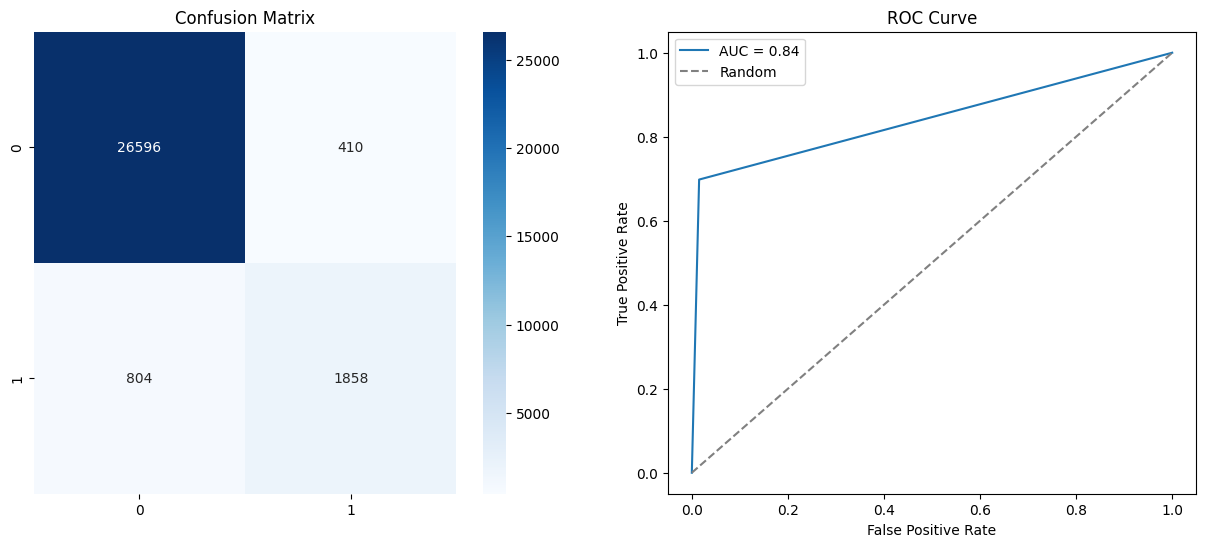

In [66]:
plot_binary_roc_curve(pred_df)

In [56]:
# def plot_roc_curve(results):
#     y_true = results['image_label']
#     y_score_class1 = results['benign_posteriors']
#     y_score_class2 = results['malignant_posteriors']

#     fpr_class1, tpr_class1, thresholds_class1 = roc_curve(y_true, y_score_class1, pos_label = 0)
#     roc_auc_class1 = auc(fpr_class1, tpr_class1)

#     # Compute ROC curve and AUC for class 2
#     fpr_class2, tpr_class2, thresholds_class2 = roc_curve(y_true, y_score_class2, pos_label = 1)
#     roc_auc_class2 = auc(fpr_class2, tpr_class2)

#     # Plot ROC curve for class 1
#     plt.figure()
#     plt.plot(fpr_class1, tpr_class1, color='blue', lw=2, label='Class 1 ROC curve (area = %0.2f)' % roc_auc_class1)
    
#     # Plot ROC curve for class 2
#     plt.plot(fpr_class2, tpr_class2, color='red', lw=2, label='Class 2 ROC curve (area = %0.2f)' % roc_auc_class2)
#     plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic (ROC)')
#     plt.legend(loc='lower right')
#     plt.show()

# plot_roc_curve(pred_df)